In [1]:
import io

import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import table

import specutils, specutils.fitting, specutils.analysis

from astroquery.sdss import SDSS

from IPython import display

%matplotlib inline
from matplotlib import pyplot as plt

/Users/erik/miniconda3/envs/glue-jupyter/lib/python3.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
spec_file = SDSS.get_spectra(plate=6497, mjd=56329, fiberID=139)[0]
spec_file.writeto('spectrum.fits', overwrite=True)
spec = specutils.Spectrum1D.read('spectrum.fits', format='SDSS-III/IV spec')

/Users/erik/miniconda3/envs/glue-jupyter/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [3]:
url = 'http://skyserver.sdss.org/dr12/SkyserverWS/ImgCutout/getjpeg?ra={}&dec={}&width=256&height=256&scale=.1'.format(spec_file[0].header['PLUG_RA'], spec_file[0].header['PLUG_DEC'])
display.Image(url=url)

Create a continuum-subtracted spectrum:

In [4]:
basic_continuum = specutils.fitting.fit_generic_continuum(spec)
subspec = spec - basic_continuum(spec.spectral_axis)

Define some important known bright galaxy emission lines:

In [5]:
bright_lines = {'Ha': 6562.801*u.AA, 'Hb':4861.363*u.AA, 'OIIIa':4958.911*u.AA, 'OIIIb':5006.843*u.AA,
                'OII':3727*u.AA # a doublet so this is ballpark
               } 

# Identify line regions 

## Non-interactive version

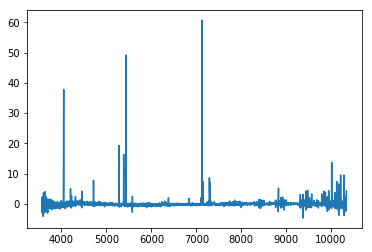

In [6]:
plt.step(subspec.wavelength.to(u.angstrom), subspec.flux)

That looks like a classic emission line spectrum, but now I need to zoom in by hand to find the lines.  Lets start with $H\alpha$

(7000, 7200)

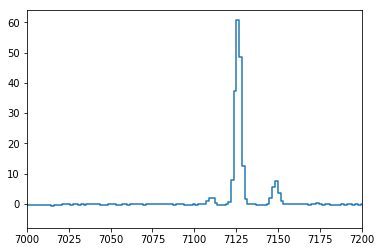

In [7]:
plt.step(subspec.wavelength.to(u.angstrom), subspec.flux)
plt.xlim(7000, 7200)

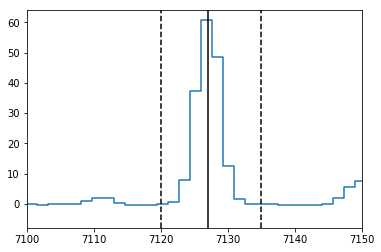

In [8]:
plt.step(subspec.wavelength, subspec.flux, where='mid')
plt.xlim(7100, 7150)

halpha_region = specutils.SpectralRegion(7120*u.angstrom, 7135*u.angstrom)
plt.axvline(halpha_region.lower.to(subspec.wavelength.unit).value, c='k', ls='--')
plt.axvline(halpha_region.upper.to(subspec.wavelength.unit).value, c='k', ls='--')

halpha_center = specutils.analysis.centroid(subspec, halpha_region)
plt.axvline(halpha_center.value, c='k', ls='-')

In the above I had to hand-adjust the locations of the lines to find the right wl bounds.  So now I can *guess* the redshift:

In [9]:
halpha_z = halpha_center/bright_lines['Ha'] - 1
halpha_z

<Quantity 0.08598871>

Which lets me estimate where all the other lines should be:

In [10]:
for nm, wl in bright_lines.items():
    print(nm, (1+halpha_z)*wl)

Ha 7127.127797940857 Angstrom
Hb 5279.385337629643 Angstrom
OIIIa 5385.321364401372 Angstrom
OIIIb 5437.374975292652 Angstrom
OII 4047.4799255570256 Angstrom


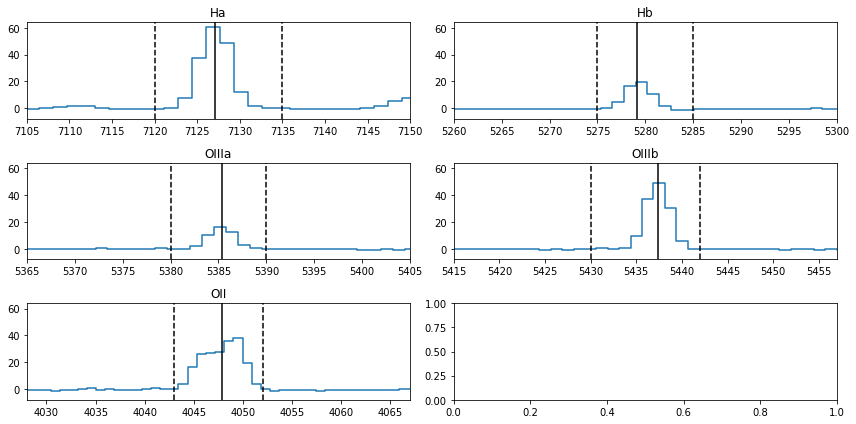

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(12, 6))

regions = {'Ha': halpha_region,
           'Hb': specutils.SpectralRegion(5275*u.angstrom, 5285*u.angstrom),
           'OIIIa': specutils.SpectralRegion(5380*u.angstrom, 5390*u.angstrom),
           'OIIIb': specutils.SpectralRegion(5430*u.angstrom, 5442*u.angstrom),
           'OII': specutils.SpectralRegion(4043*u.angstrom, 4052*u.angstrom)
          }

for ax, (line, reg) in zip(axs.ravel(), regions.items()):
    centroid = specutils.analysis.centroid(subspec, reg)
    ax.step(subspec.wavelength, subspec.flux, where='mid')
    ax.axvline(reg.lower.value, c='k', ls='--')
    ax.axvline(reg.upper.value, c='k', ls='--')
    ax.axvline(centroid.value, c='k', ls='-')
    ax.set_xlim((reg.lower-15*u.angstrom).value, (reg.upper+15*u.angstrom).value)
    ax.set_title(line)
    
plt.tight_layout()

As before, the numbers in the "regions" dictionary had to be manually tweaked and the cell re-executed.

But that required a lot of manual plotting.  Even better would be to be able to get regions fit interactively!:

## Interactive version

How to use: Execute the next three cells (until you see a spectrum). 

In the spectrum view, select the region for a spectral line to be identified.  Then hit "Record line".  This should also populate an estimate for a redshift  Select the next line and hit "jump", recording if desired.  Continue until all lines are populated.

In [12]:
import helper_library

In [13]:
line_finder = helper_library.SpectrumLineFinder(subspec, bright_lines)

In [14]:
line_finder.show()

In [15]:
# uncommenting this will use the interactive results for the final section instead of the non-interactive
#regions = line_finder.get_regions()

Improvements desired:

* Hide the state panel and the  - it's a distraction.
* Make the spectrum a "line"
* Show the uncertainty as a fainter line

# Estimate redshift

Lets display the results for all the lines in a table:

In [16]:
tab = table.QTable()
tab['name'] = table.Column(dtype='S10')
tab['centroid'] = table.Column(dtype=float, unit=u.angstrom)
tab['rest'] = table.Column(dtype=float, unit=u.angstrom)
for name in bright_lines:
    centroid = specutils.analysis.centroid(subspec, regions[name])
    tab.add_row([name, centroid, bright_lines[name]]) 
    
tab['z'] = (tab['centroid']/tab['rest']) - 1
tab

name,centroid,rest,z
,Angstrom,Angstrom,
bytes10,float64,float64,float64
Ha,7127.127797940857,6562.801,0.08598871090878069
Hb,5279.094044643962,4861.363,0.08592879088518202
OIIIa,5385.353607416141,4958.911,0.08599521294416079
OIIIb,5437.34040226577,5006.843,0.08598180575379932
OII,4047.807939195805,3727.0,0.08607672100772867


And then estimate the redshift from all of these combined:

In [17]:
z_mean = np.mean(tab['z'])
z_mean

<Quantity 0.08599425>

In [18]:
z_std = np.std(tab['z'])
z_std

<Quantity 4.74822722e-05>

In [19]:
percent_uncertainty = (z_std/z_mean).to(u.percent)
percent_uncertainty

<Quantity 0.05521564 %>